In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ICLR_2018.csv')

In [ ]:
df = df.drop(['Year','ReviewId'],axis = 1)
df.head()

,ReviewText,Confidence
0,This paper proposes a method for multitask and...,4
1,The authors propose techniques for multitask a...,4
2,The idea of using cross-task transfer performa...,4
3,\nSummary: \n- This paper proposes a hand-desi...,3
4,Summary\n - This paper mainly focuses on a cou...,3


In [ ]:
df['Confidence'].value_counts()

4    1507
3     728
5     561
2     137
1      34
Name: Confidence, dtype: int64

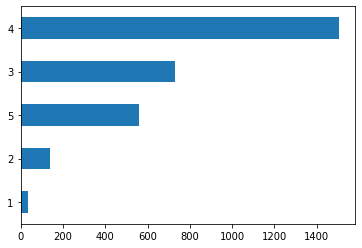

In [ ]:
label_col = pd.get_dummies(df['Confidence'])
label_col.sum().sort_values().plot(kind="barh");

365.12706437478937
22.62015503875969


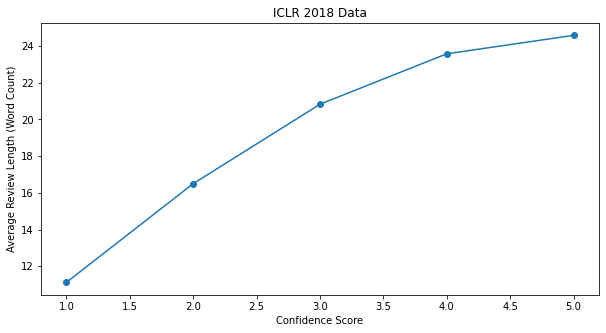

In [ ]:
df['rev_words'] = df['ReviewText'].astype(str).apply(lambda x : x.split(" ")).apply(lambda x : len(x))
df['rev_sentences'] = df['ReviewText'].astype(str).apply(lambda x : x.split(".")).apply(lambda x : len(x))
print(df['rev_words'].mean())
print(df['rev_sentences'].mean())
group = df.groupby('Confidence')['rev_sentences'].mean()
fig = plt.figure(figsize = (10, 5))
plt.plot(group.keys(), group , marker='o')
plt.xlabel("Confidence Score")
plt.ylabel("Average Review Length (Word Count)")
plt.title("ICLR 2018 Data")
plt.show()

In [ ]:
print("mean words for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_words"].mean()))
print("mean words for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_words"].mean()))
print("mean sentences for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_sentences"].mean()))
print("mean sentences for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_sentences"].mean()))

mean words for Confidence >= 3 371.71888412017165
mean words for Confidence < 3 257.34502923976606
mean sentences for Confidence >= 3 23.06008583690987
mean sentences for Confidence < 3 15.426900584795321


In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df['ReviewText'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# X = corpus
# y = df.iloc[:, 1].values
# # y = label_binarize(y, classes=[1, 2, 3, 4, 5])
# # n_classes = y.shape[1]

# # Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1), 
    dtype='double',
)
data = vectorizer.fit_transform(corpus)
vectors=data
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(data)
data=tfidf_transformer.transform(data)

In [ ]:
data.shape

(2967, 12595)

Reducing the dimentionality of the data

In [ ]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=50)
data = pca.fit_transform(data)

In [ ]:
data.shape

(2967, 12595)

In [ ]:
y = df.iloc[:, 1].values
# y = label_binarize(y, classes=[1, 2, 3, 4, 5])
n_classes = 5

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(2373, 12595)
(2373,)


### Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
from matplotlib import pyplot
import seaborn as sns
def metrics(expected , predicted):
  # Mean absolute error
  print("The rmse is " + str(np.sqrt(mean_squared_error(expected, predicted))))
  print("The mae is " + str(mean_absolute_error(expected, predicted)))
  print("The r2 is " + str(r2_score(expected, predicted)))
  print("Standard Deviation of predicted" + str(np.std(predicted)))
  plt.figure()
  ax1 = sns.distplot(predicted)
  ax2 = sns.distplot(expected)
  plt.axvline(np.mean(predicted) , color='b' , linestyle='dashed' , linewidth='2')
  plt.axvline(np.mean(expected) , color='orange' , linestyle='dashed' , linewidth='2')
  # pyplot.plot(err)
  # pyplot.xticks(ticks=[i for i in range(len(err))], labels=predicted)
  # pyplot.xlabel('Predicted Value')
  # pyplot.ylabel('Mean Squared Error')
  # pyplot.show()
  # mean sq error
  # r2



## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

### Metrics

The rmse is 1.055698298970646
The mae is 0.767863823419379
The r2 is -0.6963471993949146
Standard Deviation of predicted0.8664365460861105
And for training values -------------------
The rmse is 0.061203304271984005
The mae is 0.0030903216743924707
The r2 is 0.994623727170806
Standard Deviation of predicted0.8324604845500695


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

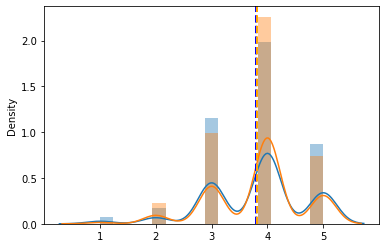

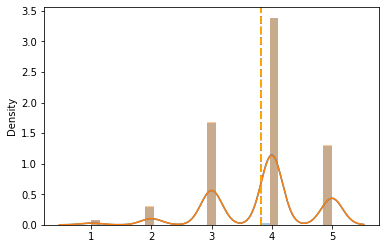

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

# ICLR 2019

In [ ]:
from google.colab import files
df = files.upload()

Saving 2019_iclr.csv to 2019_iclr.csv


In [ ]:
df = pd.read_csv("/content/2019_iclr.csv")

In [ ]:
df.head()

,Unnamed: 0,title,review,rating,confidence,Decision
0,0,An interesting approach ; some concerns regard...,The paper proposes an approach to learn nonlin...,4: Ok but not good enough - rejection,5: The reviewer is absolutely certain that the...,NaN
1,1,A easy-to-follow paper on nonlinear Granger ca...,"This paper aims to estimate time-delayed, nonl...",4: Ok but not good enough - rejection,4: The reviewer is confident but not absolutel...,NaN
2,2,Interesting approach,"In the manuscript entitled ""Neural Causal Disc...","8: Top 50% of accepted papers, clear accept",4: The reviewer is confident but not absolutel...,NaN
3,3,unconvincing experiments; original theorem sta...,NaN,NaN,4: The area chair is confident but not absolut...,Reject
4,4,"The paper is not bad technically, but the cont...",Major Contribution:\nThis paper details a meth...,4: Ok but not good enough - rejection,5: The reviewer is absolutely certain that the...,NaN


In [ ]:
df = df.drop(['title','Decision' , "rating" , "Unnamed: 0"],axis = 1)
df.dropna(inplace=True)
df["confidence"] = df['confidence'].apply(lambda x : x[0])
df.rename(columns = {"review" : "ReviewText" , "confidence" : "Confidence"} , inplace=True)
# df.reset_index(inplace=True)
df.head()

,ReviewText,Confidence
0,The paper proposes an approach to learn nonlin...,5
1,"This paper aims to estimate time-delayed, nonl...",4
2,"In the manuscript entitled ""Neural Causal Disc...",4
4,Major Contribution:\nThis paper details a meth...,5
5,# Summary\n\nThis submission proposes a multi-...,4


In [ ]:
df['Confidence'].value_counts()

4    2378
3    1239
5     832
2     275
1      40
Name: Confidence, dtype: int64

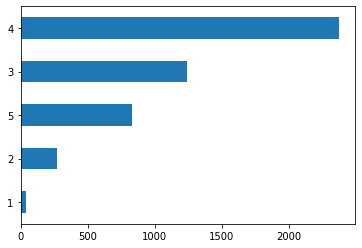

In [ ]:
label_col = pd.get_dummies(df['Confidence'])
label_col.sum().sort_values().plot(kind="barh");

394.8352225020991
24.49790092359362


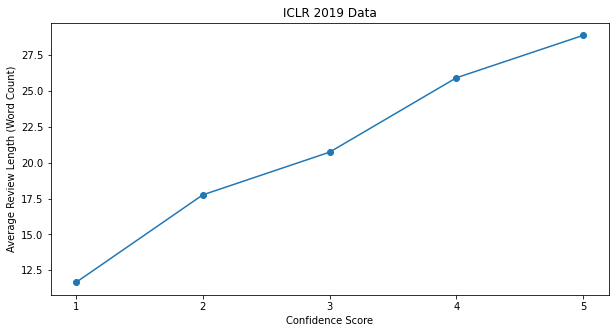

In [ ]:
df['rev_words'] = df['ReviewText'].astype(str).apply(lambda x : x.split(" ")).apply(lambda x : len(x))
df['rev_sentences'] = df['ReviewText'].astype(str).apply(lambda x : x.split(".")).apply(lambda x : len(x))
print(df['rev_words'].mean())
print(df['rev_sentences'].mean())
group = df.groupby('Confidence')['rev_sentences'].mean()
fig = plt.figure(figsize = (10, 5))
plt.plot(group.keys(), group , marker='o')
plt.xlabel("Confidence Score")
plt.ylabel("Average Review Length (Word Count)")
plt.title("ICLR 2019 Data")
plt.show()

In [ ]:
df['Confidence'] = df['Confidence'].astype(int)

In [ ]:
print("mean words for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_words"].mean()))
print("mean words for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_words"].mean()))
print("mean sentences for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_sentences"].mean()))
print("mean sentences for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_sentences"].mean()))

mean words for Confidence >= 3 403.2539896605979
mean words for Confidence < 3 275.9301587301587
mean sentences for Confidence >= 3 25.030119127893908
mean sentences for Confidence < 3 16.98095238095238


In [ ]:
df = df.reset_index()

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df['ReviewText'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# X = corpus
# y = df.iloc[:, 1].values
# # y = label_binarize(y, classes=[1, 2, 3, 4, 5])
# # n_classes = y.shape[1]

# # Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1), 
    dtype='double',
)
data = vectorizer.fit_transform(corpus)
vectors=data
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(data)
data=tfidf_transformer.transform(data)

In [ ]:
data.shape

(4764, 16144)

Reducing the dimentionality of the data

In [ ]:
# from sklearn.decomposition import TruncatedSVD
# pca = TruncatedSVD(n_components=50)
# data = pca.fit_transform(data)

In [ ]:
data.shape

(4764, 16144)

In [ ]:
df.head()

,index,ReviewText,Confidence,rev_words,rev_sentences
0,0,The paper proposes an approach to learn nonlin...,5,228,15
1,1,"This paper aims to estimate time-delayed, nonl...",4,490,27
2,2,"In the manuscript entitled ""Neural Causal Disc...",4,336,12
3,4,Major Contribution:\nThis paper details a meth...,5,369,20
4,5,# Summary\n\nThis submission proposes a multi-...,4,1022,60


In [ ]:
df["Confidence"] = df["Confidence"].astype(int)
y = df.iloc[:, 2].values
# y = label_binarize(y, classes=[1, 2, 3, 4, 5])
n_classes = 5

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(3811, 16144)
(3811,)


In [ ]:
y_train

array([4, 3, 3, ..., 4, 3, 3])

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)

### Metrics

The rmse is 1.1162232377734558
The mae is 0.8129745077464354
The r2 is -0.7595214032103281
Standard Deviation of predicted0.8337127412754703
And for training values -------------------
The rmse is 0.04303746553745506
The mae is 0.002407890471853921
The r2 is 0.9972982307026695
Standard Deviation of predicted0.8268658985092269


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

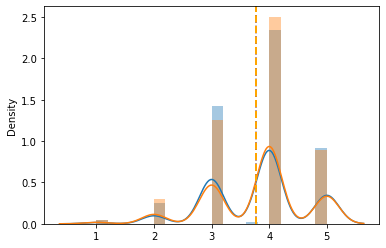

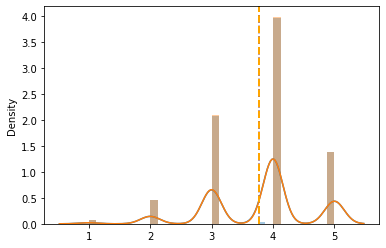

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)

# 2021

In [ ]:
from google.colab import files
df = files.upload()

Saving 2021_iclr.csv to 2021_iclr.csv


In [ ]:
import pandas as pd
df = pd.read_csv("/content/2021_iclr.csv")

In [ ]:
df.head()

,review,rating,confidence
0,Review:\n\nThis paper carries out a large-scal...,"Rating: 7: Good paper, accept",Confidence: 4: The reviewer is confident but n...
1,Review:\n\n###################################...,"Rating: 9: Top 15% of accepted papers, strong ...",Confidence: 3: The reviewer is fairly confiden...
2,Review:\n\nThe authors survey a wide variety o...,"Rating: 9: Top 15% of accepted papers, strong ...",Confidence: 3: The reviewer is fairly confiden...
3,Review:\n\nThe paper presents an empirical eva...,"Rating: 7: Good paper, accept",Confidence: 4: The reviewer is confident but n...
4,"Review:\n\nIn general, it is not clear, at lea...","Rating: 9: Top 15% of accepted papers, strong ...",Confidence: 4: The reviewer is confident but n...


In [ ]:
df = df.drop(["rating"],axis = 1)
df.dropna(inplace=True)
df["confidence"] = df['confidence'].apply(lambda x : x[12])
df.rename(columns = {"review" : "ReviewText" , "confidence" : "Confidence"} , inplace=True)
# df.reset_index(inplace=True)
df.head()

,ReviewText,Confidence
0,Review:\n\nThis paper carries out a large-scal...,4
1,Review:\n\n###################################...,3
2,Review:\n\nThe authors survey a wide variety o...,3
3,Review:\n\nThe paper presents an empirical eva...,4
4,"Review:\n\nIn general, it is not clear, at lea...",4


In [ ]:
df['Confidence'].value_counts()

4    1610
3    1042
5     413
2     199
1      26
Name: Confidence, dtype: int64

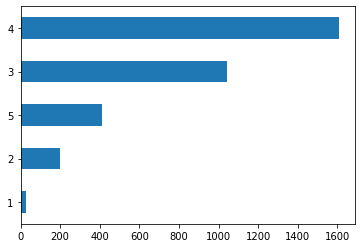

In [ ]:
label_col = pd.get_dummies(df['Confidence'])
label_col.sum().sort_values().plot(kind="barh");

436.4914893617021
26.26869300911854


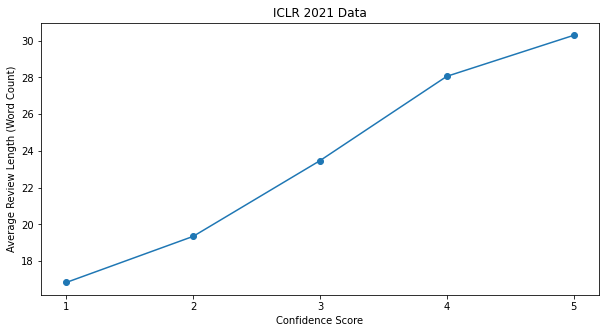

In [ ]:
df['rev_words'] = df['ReviewText'].astype(str).apply(lambda x : x.split(" ")).apply(lambda x : len(x))
df['rev_sentences'] = df['ReviewText'].astype(str).apply(lambda x : x.split(".")).apply(lambda x : len(x))
print(df['rev_words'].mean())
print(df['rev_sentences'].mean())
group = df.groupby('Confidence')['rev_sentences'].mean()
fig = plt.figure(figsize = (10, 5))
plt.plot(group.keys(), group , marker='o')
plt.xlabel("Confidence Score")
plt.ylabel("Average Review Length (Word Count)")
plt.title("ICLR 2021 Data")
plt.show()

In [ ]:
df = df.reset_index()

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df['ReviewText'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# X = corpus
# y = df.iloc[:, 1].values
# # y = label_binarize(y, classes=[1, 2, 3, 4, 5])
# # n_classes = y.shape[1]

# # Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1), 
    dtype='double',
)
data = vectorizer.fit_transform(corpus)
vectors=data
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(data)
data=tfidf_transformer.transform(data)

In [ ]:
data.shape

(3290, 14834)

Reducing the dimentionality of the data

In [ ]:
# from sklearn.decomposition import TruncatedSVD
# pca = TruncatedSVD(n_components=50)
# data = pca.fit_transform(data)

In [ ]:
data.shape

(3290, 14834)

In [ ]:
df.head()

,index,ReviewText,Confidence,rev_words,rev_sentences
0,0,Review:\n\nThis paper carries out a large-scal...,4,372,22
1,1,Review:\n\n###################################...,3,97,9
2,2,Review:\n\nThe authors survey a wide variety o...,3,1061,66
3,3,Review:\n\nThe paper presents an empirical eva...,4,246,16
4,4,"Review:\n\nIn general, it is not clear, at lea...",4,536,36


In [ ]:
df["Confidence"] = df["Confidence"].astype(int)

In [ ]:
print("mean words for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_words"].mean()))
print("mean words for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_words"].mean()))
print("mean sentences for Confidence >= 3 " + str(df.loc[df['Confidence'] >= 3]["rev_sentences"].mean()))
print("mean sentences for Confidence < 3 " + str(df.loc[df['Confidence'] < 3]["rev_sentences"].mean()))

mean words for Confidence >= 3 445.68613376835236
mean words for Confidence < 3 311.24
mean sentences for Confidence >= 3 26.797716150081566
mean sentences for Confidence < 3 19.06222222222222


In [ ]:
df["Confidence"] = df["Confidence"].astype(int)
y = df.iloc[:, 2].values
# y = label_binarize(y, classes=[1, 2, 3, 4, 5])
n_classes = 5

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(2632, 14834)
(2632,)


## Decision Tree

In [ ]:
X_train.shape

(2632, 14834)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
expected = y_test
predicted = regressor.predict(X_test)

### Metrics

The rmse is 1.0619131671036408
The mae is 0.7781155015197568
The r2 is -0.7860746203682363
Standard Deviation of predicted0.7900879487437601
And for training values -------------------
The rmse is 0.0
The mae is 0.0
The r2 is 1.0
Standard Deviation of predicted0.8032989578802913


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

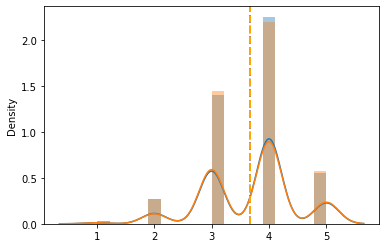

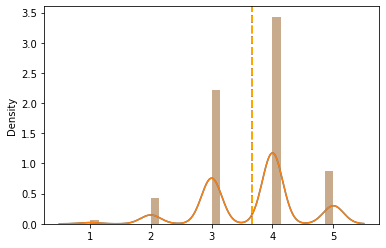

In [ ]:
metrics(y_test , predicted)
print("And for training values -------------------")
predicted2 = regressor.predict(X_train)
metrics(y_train , predicted2)